# 06 - ML Models
XGBoost and LSTM for trade profitability prediction

In [29]:
import sys
sys.path.append('..')

# Force reload of modules
import importlib
import src.ml_models
import src.strategy
importlib.reload(src.ml_models)
importlib.reload(src.strategy)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from src.strategy import EMARegimeStrategy, MLFilteredStrategy, trades_to_dataframe
from src.backtest import split_data, calculate_metrics, compare_strategies
from src.ml_models import XGBoostModel, LSTMModel, prepare_ml_dataset, evaluate_model

In [19]:
feature_df = pd.read_csv('../data/nifty_features_5min.csv', parse_dates=['timestamp'])
print(f"Loaded data: {feature_df.shape}")

Loaded data: (19467, 87)


In [20]:
train_df, test_df = split_data(feature_df, train_ratio=0.7)

strategy = EMARegimeStrategy(fast_period=5, slow_period=15)
train_df_signals = strategy.generate_signals(train_df)
train_trades = strategy.run(train_df_signals)
train_trades_df = trades_to_dataframe(train_trades)

print(f"Training trades: {len(train_trades_df)}")
print(f"Profitable: {(train_trades_df['pnl'] > 0).sum()}")
print(f"Unprofitable: {(train_trades_df['pnl'] <= 0).sum()}")

Training trades: 409
Profitable: 131
Unprofitable: 278


In [21]:
X_train, y_train = prepare_ml_dataset(train_df_signals, train_trades_df)
print(f"\nML Dataset:")
print(f"  Features shape: {X_train.shape}")
print(f"  Target distribution: {y_train.value_counts().to_dict()}")
print(f"  Feature columns: {list(X_train.columns)[:10]}...")


ML Dataset:
  Features shape: (416, 70)
  Target distribution: {0: 285, 1: 131}
  Feature columns: ['futures_oi', 'atm_call_iv', 'atm_call_oi', 'atm_call_volume', 'atm_put_iv', 'atm_put_oi', 'atm_put_volume', 'total_call_oi', 'total_put_oi', 'total_call_volume']...


In [22]:
print("=" * 50)
print("TRAINING XGBOOST MODEL")
print("=" * 50)

xgb_model = XGBoostModel({
    'objective': 'binary:logistic',
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'eval_metric': 'logloss',
    'base_score': 0.5
})

cv_results = xgb_model.fit(X_train, y_train, cv_folds=5)
print(f"\nCross-Validation Results:")
print(f"  Mean CV Accuracy: {cv_results['mean_cv_score']:.4f}")
print(f"  Std CV Accuracy: {cv_results['std_cv_score']:.4f}")

TRAINING XGBOOST MODEL

Cross-Validation Results:
  Mean CV Accuracy: 0.6145
  Std CV Accuracy: 0.0612


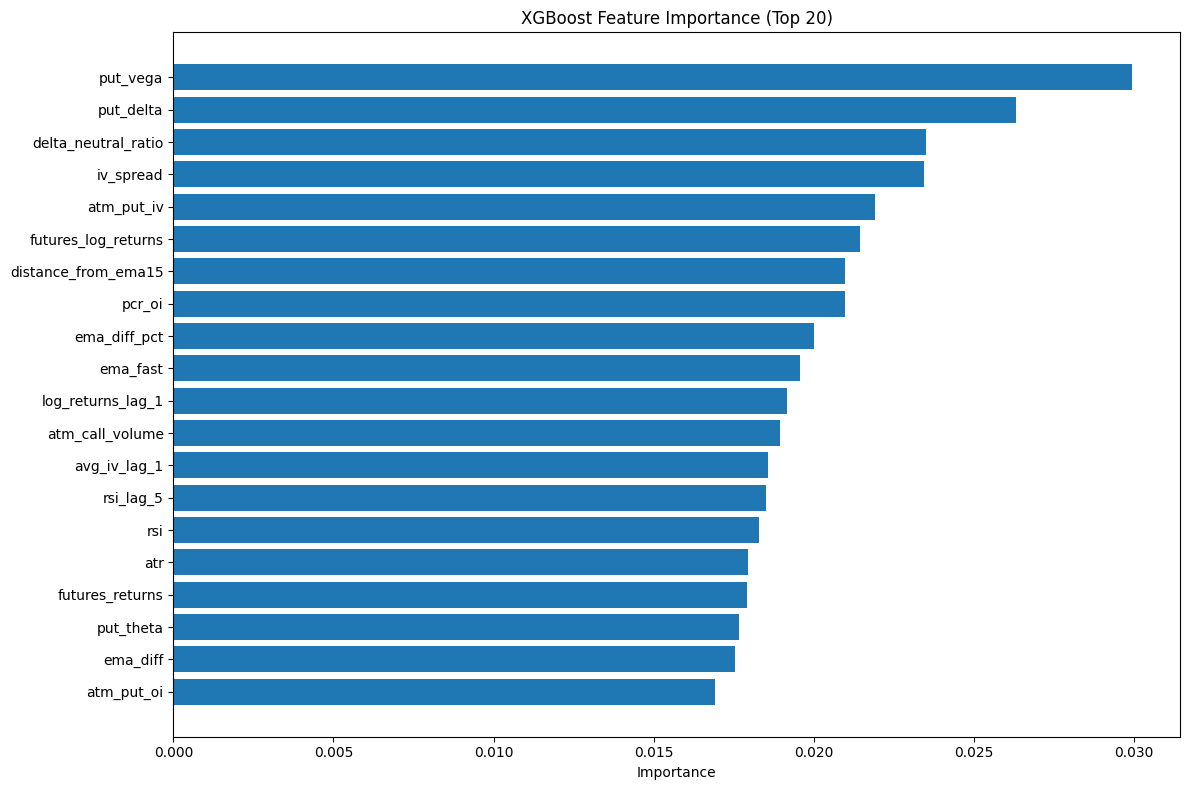

In [23]:
feature_importance = xgb_model.get_feature_importance()

plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20).sort_values('importance', ascending=True)
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Importance')
plt.title('XGBoost Feature Importance (Top 20)')
plt.tight_layout()
plt.savefig('../plots/06_xgb_importance.png', dpi=150)
plt.show()

In [24]:
print("=" * 50)
print("TRAINING LSTM MODEL")
print("=" * 50)

lstm_model = LSTMModel(sequence_length=10, lstm_units=64, dropout=0.2)
lstm_results = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

print(f"\nLSTM Training Results:")
print(f"  Final Loss: {lstm_results['final_loss']:.4f}")
print(f"  Final Accuracy: {lstm_results['final_accuracy']:.4f}")
print(f"  Validation Accuracy: {lstm_results['val_accuracy']:.4f}")

TRAINING LSTM MODEL

LSTM Training Results:
  Final Loss: 0.0443
  Final Accuracy: 0.9877
  Validation Accuracy: 0.5854


In [25]:
print("=" * 50)
print("BACKTESTING WITH ML FILTER")
print("=" * 50)

test_strategy = EMARegimeStrategy(fast_period=5, slow_period=15)
test_df_signals = test_strategy.generate_signals(test_df)
baseline_trades = test_strategy.run(test_df_signals)
baseline_trades_df = trades_to_dataframe(baseline_trades)
baseline_metrics = calculate_metrics(baseline_trades_df)

print(f"\nBaseline Strategy:")
print(f"  Trades: {baseline_metrics.total_trades}")
print(f"  Win Rate: {baseline_metrics.win_rate:.2f}%")
print(f"  Total Return: {baseline_metrics.total_return_pct:.2f}%")
print(f"  Sharpe: {baseline_metrics.sharpe_ratio:.3f}")

BACKTESTING WITH ML FILTER

Baseline Strategy:
  Trades: 144
  Win Rate: 27.78%
  Total Return: -0.90%
  Sharpe: -9.177


In [30]:
xgb_strategy = MLFilteredStrategy(model=xgb_model, confidence_threshold=0.5, fast_period=5, slow_period=15)
xgb_strategy.set_feature_columns(xgb_model.feature_columns)

test_df_signals_xgb = xgb_strategy.generate_signals(test_df)
xgb_trades = xgb_strategy.run_with_ml(test_df_signals_xgb)
xgb_trades_df = trades_to_dataframe(xgb_trades)
xgb_metrics = calculate_metrics(xgb_trades_df)

print(f"\nXGBoost Filtered Strategy:")
print(f"  Trades: {xgb_metrics.total_trades}")
print(f"  Win Rate: {xgb_metrics.win_rate:.2f}%")
print(f"  Total Return: {xgb_metrics.total_return_pct:.2f}%")
print(f"  Sharpe: {xgb_metrics.sharpe_ratio:.3f}")


XGBoost Filtered Strategy:
  Trades: 33
  Win Rate: 24.24%
  Total Return: -0.34%
  Sharpe: -17.954


In [31]:
lstm_strategy = MLFilteredStrategy(model=lstm_model, confidence_threshold=0.5, fast_period=5, slow_period=15)
lstm_strategy.set_feature_columns(lstm_model.feature_columns)

test_df_signals_lstm = lstm_strategy.generate_signals(test_df)
lstm_trades = lstm_strategy.run_with_ml(test_df_signals_lstm)
lstm_trades_df = trades_to_dataframe(lstm_trades)
lstm_metrics = calculate_metrics(lstm_trades_df)

print(f"\nLSTM Filtered Strategy:")
print(f"  Trades: {lstm_metrics.total_trades}")
print(f"  Win Rate: {lstm_metrics.win_rate:.2f}%")
print(f"  Total Return: {lstm_metrics.total_return_pct:.2f}%")
print(f"  Sharpe: {lstm_metrics.sharpe_ratio:.3f}")


LSTM Filtered Strategy:
  Trades: 47
  Win Rate: 17.02%
  Total Return: -1.84%
  Sharpe: -95.783


In [32]:
print("\n" + "=" * 60)
print("PERFORMANCE COMPARISON")
print("=" * 60)

comparison_df = pd.DataFrame({
    'Metric': ['Total Trades', 'Win Rate (%)', 'Total Return (%)', 'Sharpe Ratio', 
               'Sortino Ratio', 'Max Drawdown (%)', 'Profit Factor'],
    'Baseline': [baseline_metrics.total_trades, baseline_metrics.win_rate, 
                 baseline_metrics.total_return_pct, baseline_metrics.sharpe_ratio,
                 baseline_metrics.sortino_ratio, baseline_metrics.max_drawdown_pct,
                 baseline_metrics.profit_factor],
    'XGBoost': [xgb_metrics.total_trades, xgb_metrics.win_rate,
                xgb_metrics.total_return_pct, xgb_metrics.sharpe_ratio,
                xgb_metrics.sortino_ratio, xgb_metrics.max_drawdown_pct,
                xgb_metrics.profit_factor],
    'LSTM': [lstm_metrics.total_trades, lstm_metrics.win_rate,
             lstm_metrics.total_return_pct, lstm_metrics.sharpe_ratio,
             lstm_metrics.sortino_ratio, lstm_metrics.max_drawdown_pct,
             lstm_metrics.profit_factor]
})
print(comparison_df.to_string(index=False))


PERFORMANCE COMPARISON
          Metric   Baseline    XGBoost        LSTM
    Total Trades 144.000000  33.000000   47.000000
    Win Rate (%)  27.777778  24.242424   17.021277
Total Return (%)  -0.903768  -0.343255   -1.838971
    Sharpe Ratio  -9.177139 -17.954165  -95.783200
   Sortino Ratio -30.878369 -64.981292 -201.815027
Max Drawdown (%)   1.723275   0.622561    1.791580
   Profit Factor   0.837383   0.722835    0.221101


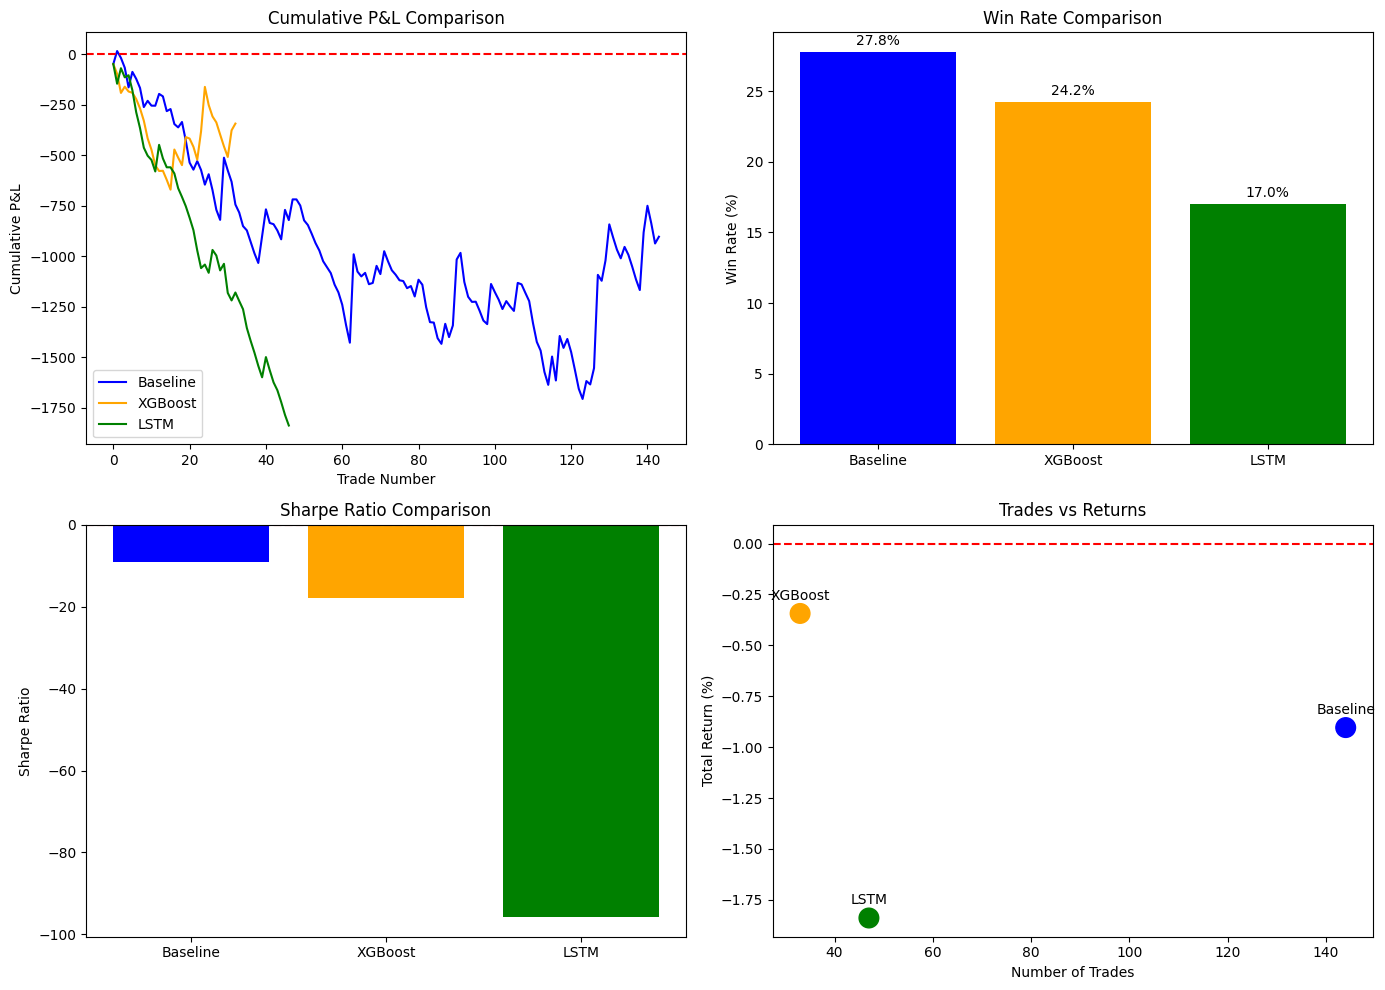

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

strategies = ['Baseline', 'XGBoost', 'LSTM']
colors = ['blue', 'orange', 'green']

if len(baseline_trades_df) > 0:
    axes[0, 0].plot(baseline_trades_df['pnl'].cumsum().values, label='Baseline', color='blue')
if len(xgb_trades_df) > 0:
    axes[0, 0].plot(xgb_trades_df['pnl'].cumsum().values, label='XGBoost', color='orange')
if len(lstm_trades_df) > 0:
    axes[0, 0].plot(lstm_trades_df['pnl'].cumsum().values, label='LSTM', color='green')
axes[0, 0].axhline(0, color='r', linestyle='--')
axes[0, 0].set_title('Cumulative P&L Comparison')
axes[0, 0].set_xlabel('Trade Number')
axes[0, 0].set_ylabel('Cumulative P&L')
axes[0, 0].legend()

win_rates = [baseline_metrics.win_rate, xgb_metrics.win_rate, lstm_metrics.win_rate]
bars = axes[0, 1].bar(strategies, win_rates, color=colors)
axes[0, 1].set_title('Win Rate Comparison')
axes[0, 1].set_ylabel('Win Rate (%)')
for bar, wr in zip(bars, win_rates):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{wr:.1f}%', ha='center')

sharpes = [baseline_metrics.sharpe_ratio, xgb_metrics.sharpe_ratio, lstm_metrics.sharpe_ratio]
bars = axes[1, 0].bar(strategies, sharpes, color=colors)
axes[1, 0].set_title('Sharpe Ratio Comparison')
axes[1, 0].set_ylabel('Sharpe Ratio')
axes[1, 0].axhline(0, color='r', linestyle='--')

trade_counts = [baseline_metrics.total_trades, xgb_metrics.total_trades, lstm_metrics.total_trades]
returns = [baseline_metrics.total_return_pct, xgb_metrics.total_return_pct, lstm_metrics.total_return_pct]
axes[1, 1].scatter(trade_counts, returns, s=200, c=colors)
for i, s in enumerate(strategies):
    axes[1, 1].annotate(s, (trade_counts[i], returns[i]), textcoords="offset points", xytext=(0,10), ha='center')
axes[1, 1].set_title('Trades vs Returns')
axes[1, 1].set_xlabel('Number of Trades')
axes[1, 1].set_ylabel('Total Return (%)')
axes[1, 1].axhline(0, color='r', linestyle='--')

plt.tight_layout()
plt.savefig('../plots/06_ml_comparison.png', dpi=150)
plt.show()

In [34]:
xgb_model.save('../models/xgboost_model.joblib')
lstm_model.save('../models/lstm_model.joblib')

comparison_df.to_csv('../results/ml_comparison.csv', index=False)
xgb_trades_df.to_csv('../results/xgb_trades.csv', index=False)
lstm_trades_df.to_csv('../results/lstm_trades.csv', index=False)

print("\nSaved:")
print("  - models/xgboost_model.joblib")
print("  - models/lstm_model.joblib")
print("  - results/ml_comparison.csv")
print("  - results/xgb_trades.csv")
print("  - results/lstm_trades.csv")


Saved:
  - models/xgboost_model.joblib
  - models/lstm_model.joblib
  - results/ml_comparison.csv
  - results/xgb_trades.csv
  - results/lstm_trades.csv
